### Visualising Convergence Rate

In [ ]:
!pip install matplotlib

In [ ]:
import re
import ast
import matplotlib.pyplot as plt

def load_accuracy(path):
    with open(path, 'r') as f:
        log_contents = f.read()

    match = re.search(r"metrics_centralized\s+({.*?})", log_contents)

    if match:
        metrics_dict = ast.literal_eval(match.group(1))
        if 'accuracy' in metrics_dict:
            return metrics_dict['accuracy']
        
def load_loss(path):
    """Extract loss as list of (round, loss) tuples"""
    with open(path, 'r') as f:
        log_contents = f.read()

    match = re.search(r"losses_centralized\s+\[(.*?)\]", log_contents, re.DOTALL)
    if match:
        try:
            loss_list = ast.literal_eval("[" + match.group(1).strip() + "]")
            return loss_list
        except Exception as e:
            print(f"Error parsing loss from {path}: {e}")
    return []

def visualise_data(path):
    with open(path, 'r') as f:
        log_contents = f.read()

    accuracy_match = re.search(r"metrics_centralized\s+({.*?})", log_contents)
    loss_match = re.search(r"losses_centralized\s+\[(.*?)\]", log_contents, re.DOTALL)

    plt.figure(figsize=(12, 5))

    # Plot accuracy if available
    if accuracy_match:
        metrics_dict = ast.literal_eval(accuracy_match.group(1))
        if 'accuracy' in metrics_dict:
            epochs, accuracies = zip(*metrics_dict['accuracy'])
            plt.subplot(1, 2, 1)
            plt.plot(lrs, accuracies, marker='o', color='blue')
            plt.title("Accuracy over Epochs")
            plt.ylim(0, 1)
            plt.xlabel("Round")
            plt.ylabel("Accuracy")
            plt.grid(True)

    if loss_match:
        loss_str = "[" + loss_match.group(1).strip() + "]"
        try:
            loss_list = ast.literal_eval(loss_str)
            loss_epochs, losses = zip(*loss_list)
            plt.subplot(1, 2, 2)
            plt.plot(loss_epochs, losses, marker='x', color='red')
            plt.title("Loss over Epochs")
            plt.xlabel("Round")
            plt.ylabel("Loss")
            plt.grid(True)
        except Exception as e:
            print("Error parsing losses:", e)

def plot_subplots(acc_datasets, loss_datasets):
    plt.rcParams['font.family'] = 'Nimbus Roman'
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

    # Plot accuracies (top row)
    for ax, (title, data) in zip(axes[0], acc_datasets.items()):
        if data:
            epochs, accuracies = zip(*data)
            ax.plot(epochs, accuracies, marker='o', color='blue')
        ax.set_title(f"{title} - GMA", fontsize=16)
        ax.set_xlabel("Round", fontsize=14)
        ax.set_ylabel("Accuracy", fontsize=14)
        ax.set_ylim(0, 1.0)
        ax.grid(True)

    # Plot losses (bottom row)
    for ax, (title, data) in zip(axes[1], loss_datasets.items()):
        if data:
            epochs, losses = zip(*data)
            ax.plot(epochs, losses, marker='x', color='red')
        ax.set_title(f"{title} - Loss", fontsize=16)
        ax.set_xlabel("Round", fontsize=14)
        ax.set_ylabel("Loss", fontsize=14)
        ax.grid(True)

    fig.suptitle("Global Main Task Accuracy and Loss Over Rounds Under Different Poisoning Rates", fontsize=22)
    plt.tight_layout(rect=[0, 0, 1, 1])  # Reserve space for suptitle
    plt.show()

In [ ]:
pr80_celeba = 'outputs/2024-12-13/16-17-43/main.log'
pr70_celeba = 'outputs/2024-12-12/23-48-00/main.log'
pr60_celeba = 'outputs/2024-12-13/13-15-11/main.log'

# Load accuracy
acc_dict = {
    "Poisoning Rate: 60%": load_accuracy(pr60_celeba),
    "Poisoning Rate: 70%": load_accuracy(pr70_celeba),
    "Poisoning Rate: 80%": load_accuracy(pr80_celeba),
}

# Load loss
loss_dict = {
    "Poisoning Rate: 60%": load_loss(pr60_celeba),
    "Poisoning Rate: 70%": load_loss(pr70_celeba),
    "Poisoning Rate: 80%": load_loss(pr80_celeba),
}

# Plot
plot_subplots(acc_dict, loss_dict)

# Plot GMA and GBA

In [ ]:
import re
import matplotlib.pyplot as plt

def extract_metrics_from_log(file_path):
    gma_values = []
    gba_values = []

    with open(file_path, 'r') as f:
        for line in f:
            if "Federated Accuracy on Clean Data (GMA)" in line:
                match = re.search(r'GMA\):\s*([0-9.]+)', line)
                if match:
                    gma_values.append(float(match.group(1)))
            elif "Global Poisoning Accuracy on Dirty Data (GBA)" in line:
                match = re.search(r'GBA\):\s*([0-9.]+)', line)
                if match:
                    gba_values.append(float(match.group(1)))
    
    return gma_values, gba_values

def plot_metrics(log_files, labels=None, pr=0.8):
    plt.figure(figsize=(12, 5), dpi=150)
    plt.rcParams['font.family'] = 'Nimbus Roman'

    # Plot GMA
    plt.subplot(1, 2, 1)
    for idx, file in enumerate(log_files):
        gma, _ = extract_metrics_from_log(file)
        label = labels[idx] if labels else f"Method {idx+1}"
        # plt.plot(gma, label=label) #, marker='o'
        plt.plot(gma, label=label, linewidth=2.5) if label == 'FedAssets' else  plt.plot(gma, label=label, alpha = 0.4)
    plt.title("GMA (Global Main Task Accuracy)", fontsize=16)
    plt.ylim(0,1)
    plt.xlabel("Round", fontsize=15)
    plt.ylabel("Clean Accuracy", fontsize=15)
    plt.legend()
    plt.grid(False)

    # Plot GBA
    plt.subplot(1, 2, 2)
    for idx, file in enumerate(log_files):
        _, gba = extract_metrics_from_log(file)
        label = labels[idx] if labels else f"Method {idx+1}"
        plt.plot(gba, label=label, linewidth=2.5) if label == 'FedAssets' else  plt.plot(gba, label=label, alpha = 0.4)
    plt.title("GBA (Global Backdoor Accuracy)", fontsize=16)
    plt.xlabel("Round", fontsize=15)
    plt.ylabel("Backdoor Accuracy", fontsize=15)
    plt.legend()
    plt.grid(False)

    plt.suptitle(f"Global Model Performance of varying methods in PR = {pr}", fontsize=18)
    plt.tight_layout()
    plt.show()


In [ ]:
log_paths = [
    'outputs/2024-12-13/21-24-56/main.log',
    'outputs/2024-12-13/17-56-42/main.log',
    'outputs/2024-12-13/16-17-43/main.log'
]

labels = ['FedAssets', 'All Benign', 'Equally Aggregate']
plot_metrics(log_paths, labels, pr=0.8)

In [ ]:
log_paths = [
    'outputs/2024-12-13/13-15-12/main.log',
    'outputs/2024-12-13/09-21-31/main.log',
    'outputs/2024-12-13/07-35-46/main.log'
]

labels = ['FedAssets', 'All Benign', 'Equally Aggregate']
plot_metrics(log_paths, labels, pr=0.6)

In [ ]:
log_paths = [
    'outputs/2024-12-12/19-55-50/main.log',
    'outputs/2024-12-12/23-48-00/main.log',
    'outputs/2024-12-12/22-18-16/main.log'
]

labels = ['FedAssets', 'All Benign', 'Equally Aggregate']
plot_metrics(log_paths, labels, pr=0.7)


=== Separability Metrics between Benign and Malicious Clients ===
   Epochs  CentroidDist  Silhouette  Bhattacharyya
0       1     11.642500      0.0193         0.3888
1       2     28.445700      0.2318         0.5986
2       5     19.137199      0.1586         0.3991
3      10     30.952000      0.3081         1.3016
4      15     18.243099      0.1562         0.5357


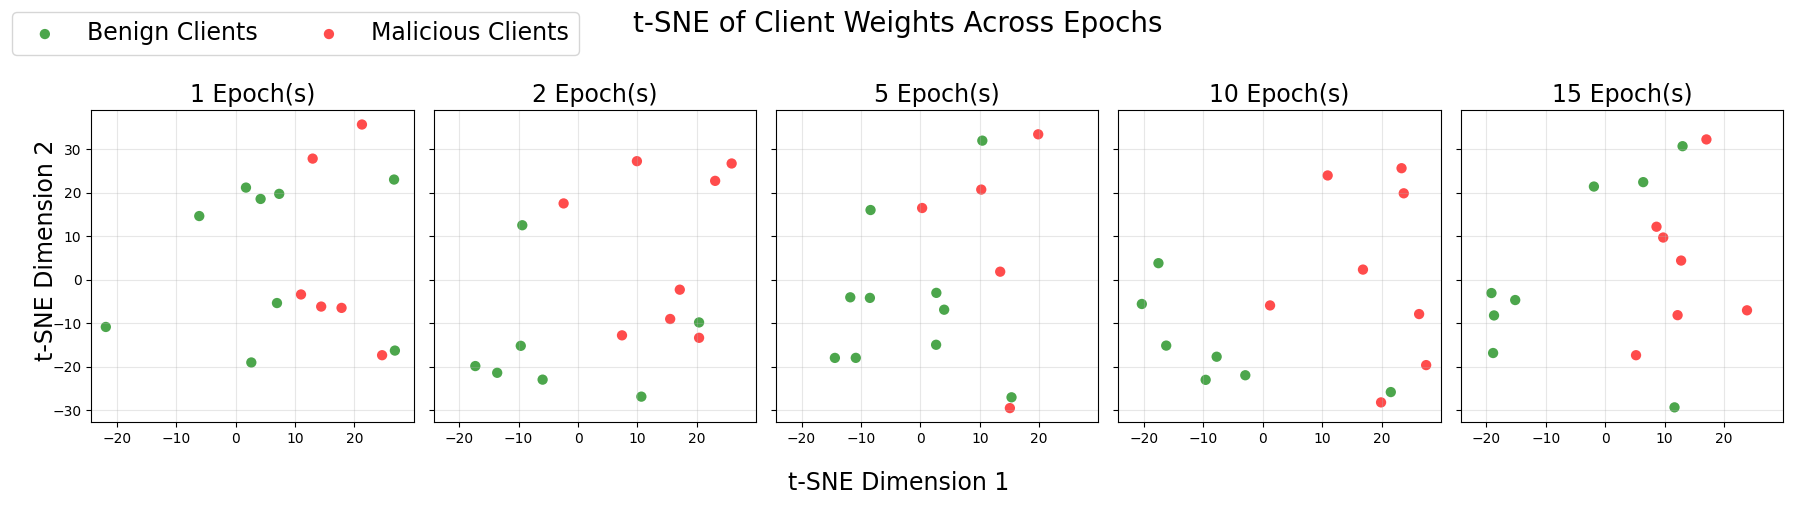

In [11]:
import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# --- Config ---
save_dir = "saved_weights"
epoch_settings = [1, 2, 5, 10, 15]

# --- Prepare containers ---
all_embeddings = []
all_labels = []        # 0=good, 1=bad, 2=evil
all_epochs = []        # to map shape markers

# --- Load and collect weights ---
for epoch in epoch_settings:
    files = [f for f in os.listdir(save_dir) if re.search(rf"epochs_{epoch}\b", f)]

    for f in sorted(files):
        list_of_weights = torch.load(os.path.join(save_dir, f), weights_only=False)

        good_layer = list_of_weights[0]
        bad_layer = list_of_weights[1]

        if len(list_of_weights) == 3:
            evil_layer = list_of_weights[2]
            w = np.concatenate((good_layer, bad_layer, np.array(evil_layer)), axis=0)
            labels = np.array([0]*len(good_layer) + [1]*len(bad_layer) + [2]*len(evil_layer))
        else:
            w = np.concatenate((good_layer, bad_layer), axis=0)
            labels = np.array([0]*len(good_layer) + [1]*len(bad_layer))

        # Flatten each client's weight vector
        flattened = w.reshape(w.shape[0], -1)
        all_embeddings.append(flattened)
        all_labels.append(labels)
        all_epochs.append(np.array([epoch]*len(labels)))

# --- Combine everything ---
X = np.concatenate(all_embeddings, axis=0)
y = np.concatenate(all_labels, axis=0)
epochs = np.concatenate(all_epochs, axis=0)

# --- Standardize and denoise ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- Run t-SNE ---
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=9, # originally 15
    learning_rate=100,
    init="pca"
)
X_embedded = tsne.fit_transform(X_pca)

# --- Quantify separability between Benign (0) and Malicious (1) clients ---
metrics = []

for epoch in epoch_settings:
    mask_benign = (epochs == epoch) & (y == 0)
    mask_malicious = (epochs == epoch) & (y == 1)
    
    X_benign = X_embedded[mask_benign]
    X_malicious = X_embedded[mask_malicious]
    
    if len(X_benign) == 0 or len(X_malicious) == 0:
        continue  # skip if not enough samples

    # --- 1. Centroid Distance ---
    centroid_benign = X_benign.mean(axis=0)
    centroid_malicious = X_malicious.mean(axis=0)
    centroid_dist = np.linalg.norm(centroid_benign - centroid_malicious)

    # --- 2. Silhouette Score (2-class separability) ---
    mask_subset = (epochs == epoch) & np.isin(y, [0, 1])
    X_subset = X_embedded[mask_subset]
    y_subset = y[mask_subset]
    sil_score = silhouette_score(X_subset, y_subset, metric='euclidean')

    # --- 3. Bhattacharyya Distance (distributional overlap) ---
    # estimate via Gaussian assumption on t-SNE coords
    mean_b, cov_b = np.mean(X_benign, axis=0), np.cov(X_benign, rowvar=False)
    mean_m, cov_m = np.mean(X_malicious, axis=0), np.cov(X_malicious, rowvar=False)
    cov_mean = (cov_b + cov_m) / 2
    diff = mean_m - mean_b
    # add a small epsilon to avoid singular matrix
    eps = 1e-6 * np.eye(cov_mean.shape[0])
    term1 = 0.125 * diff.T @ np.linalg.inv(cov_mean + eps) @ diff
    term2 = 0.5 * np.log(
        np.linalg.det(cov_mean + eps)
        / np.sqrt(np.linalg.det(cov_b + eps) * np.linalg.det(cov_m + eps))
    )
    bhattacharyya = term1 + term2

    metrics.append({
        "Epochs": epoch,
        "CentroidDist": centroid_dist,
        "Silhouette": sil_score,
        "Bhattacharyya": bhattacharyya,
    })

# --- Display results ---
df_metrics = pd.DataFrame(metrics)
print("\n=== Separability Metrics between Benign and Malicious Clients ===")
print(df_metrics.round(4))

# --- Plot settings ---
colors = {0: "green", 1: "red", 2: "black"}   # good, bad, evil
markers = {1: "v", 2: "*", 5: "o", 10: "s", 15: "^", 20: "p", 50: "h"} # circle, square, triangle, pentagon
type_names = ['Benign Clients', 'Malicious Clients', 'Evil']

fig, axes = plt.subplots(1, len(epoch_settings), figsize=(18, 5), sharex=True, sharey=True) #, sharex=True, sharey=True)

for i, epoch in enumerate(epoch_settings):
    ax = axes[i]
    for label in np.unique(y):
        mask = (epochs == epoch) & (y == label)
        if np.any(mask):
            ax.scatter(
                X_embedded[mask, 0],
                X_embedded[mask, 1],
                c=colors[label],
                marker=markers[5],
                label=type_names[label],
                alpha=0.7,
                s=55,
                edgecolors="none"
            )
    ax.set_title(f"{epoch} Epoch(s)", fontsize=17)
    ax.grid(alpha=0.3)

fig.supxlabel("t-SNE Dimension 1", fontsize=17)
fig.supylabel("t-SNE Dimension 2", fontsize=17)

# --- Legend ---
handles, labels_ = axes[2].get_legend_handles_labels()
fig.legend(handles, labels_, loc="upper left", ncol=len(type_names), fontsize=17)

plt.suptitle("t-SNE of Client Weights Across Epochs", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


=== Separability Metrics between Benign and Malicious Clients ===
   LearningRate  CentroidDist  Silhouette  Bhattacharyya
0         0.001     20.444201      0.1821         1.1031
1         0.003      6.043600      0.1267         0.4142
2         0.010     19.609800      0.1134         0.3089
3         0.030      8.306200     -0.0456         0.2935
4         0.100     21.860399      0.0810         0.2402


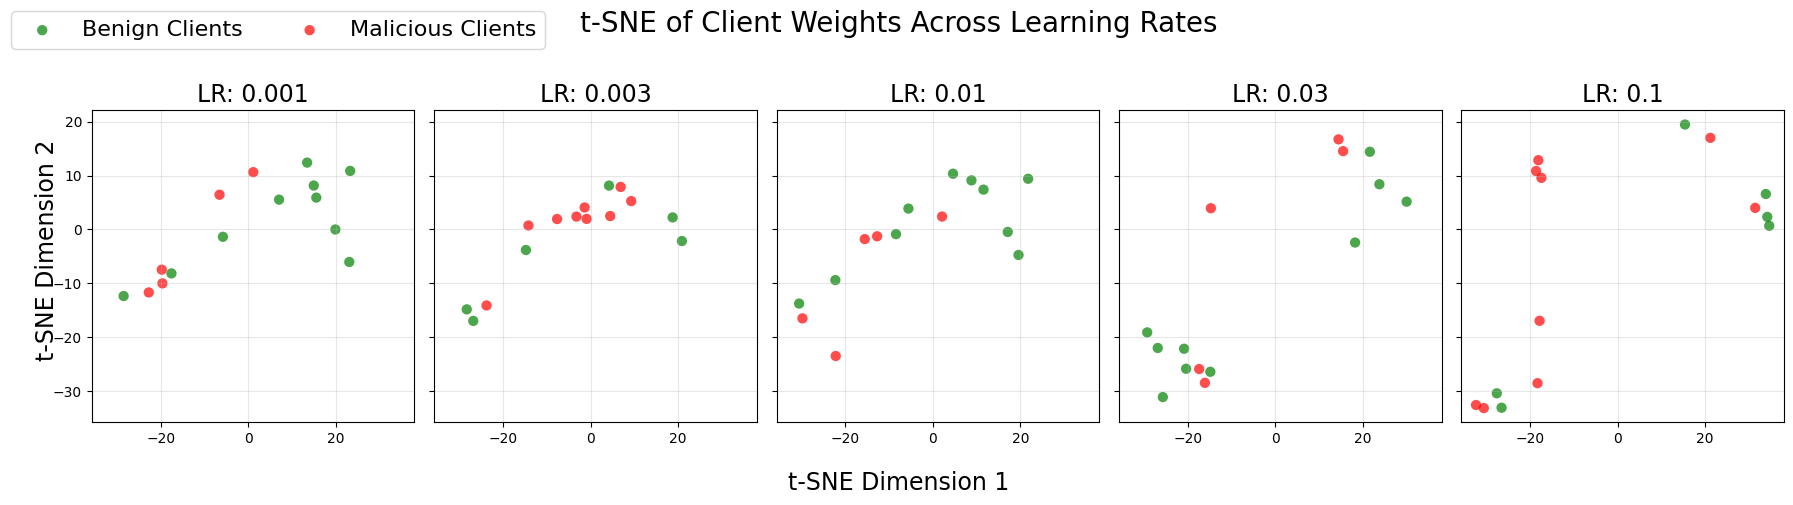

In [9]:
import os
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, pairwise_distances
from scipy.spatial.distance import cdist
import pandas as pd

# --- Config ---
save_dir = "saved_weights"
lr_settings = [0.001, 0.003, 0.01, 0.03, 0.1]

# --- Prepare containers ---
all_embeddings = []
all_labels = []        # 0=good, 1=bad, 2=evil
all_lr = []        # to map shape markers

# --- Load and collect weights ---
for lr in lr_settings:
    files = [f for f in os.listdir(save_dir) if re.search(rf"lr_{lr}\b", f)]

    for f in sorted(files):
        list_of_weights = torch.load(os.path.join(save_dir, f), weights_only=False)

        good_layer = list_of_weights[0]
        bad_layer = list_of_weights[1]

        if len(list_of_weights) == 3:
            evil_layer = list_of_weights[2]
            w = np.concatenate((good_layer, bad_layer, np.array(evil_layer)), axis=0)
            labels = np.array([0]*len(good_layer) + [1]*len(bad_layer) + [2]*len(evil_layer))
        else:
            w = np.concatenate((good_layer, bad_layer), axis=0)
            labels = np.array([0]*len(good_layer) + [1]*len(bad_layer))

        # Flatten each client's weight vector
        flattened = w.reshape(w.shape[0], -1)
        all_embeddings.append(flattened)
        all_labels.append(labels)
        all_lr.append(np.array([lr]*len(labels)))

# --- Combine everything ---
X = np.concatenate(all_embeddings, axis=0)
y = np.concatenate(all_labels, axis=0)
lrs = np.concatenate(all_lr, axis=0)

# --- Standardize and denoise ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- Run t-SNE ---
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=9, # originally 15
    learning_rate=100,
    init="pca"
)
X_embedded = tsne.fit_transform(X_pca)

# --- Quantify separability between Benign (0) and Malicious (1) clients ---
metrics = []

for lr in lr_settings:
    mask_benign = (lrs == lr) & (y == 0)
    mask_malicious = (lrs == lr) & (y == 1)
    
    X_benign = X_embedded[mask_benign]
    X_malicious = X_embedded[mask_malicious]
    
    if len(X_benign) == 0 or len(X_malicious) == 0:
        continue  # skip if not enough samples

    # --- 1. Centroid Distance ---
    centroid_benign = X_benign.mean(axis=0)
    centroid_malicious = X_malicious.mean(axis=0)
    centroid_dist = np.linalg.norm(centroid_benign - centroid_malicious)

    # --- 2. Silhouette Score (2-class separability) ---
    mask_subset = (lrs == lr) & np.isin(y, [0, 1])
    X_subset = X_embedded[mask_subset]
    y_subset = y[mask_subset]
    sil_score = silhouette_score(X_subset, y_subset, metric='euclidean')

    # --- 3. Bhattacharyya Distance (distributional overlap) ---
    # estimate via Gaussian assumption on t-SNE coords
    mean_b, cov_b = np.mean(X_benign, axis=0), np.cov(X_benign, rowvar=False)
    mean_m, cov_m = np.mean(X_malicious, axis=0), np.cov(X_malicious, rowvar=False)
    cov_mean = (cov_b + cov_m) / 2
    diff = mean_m - mean_b
    # add a small epsilon to avoid singular matrix
    eps = 1e-6 * np.eye(cov_mean.shape[0])
    term1 = 0.125 * diff.T @ np.linalg.inv(cov_mean + eps) @ diff
    term2 = 0.5 * np.log(
        np.linalg.det(cov_mean + eps)
        / np.sqrt(np.linalg.det(cov_b + eps) * np.linalg.det(cov_m + eps))
    )
    bhattacharyya = term1 + term2

    metrics.append({
        "LearningRate": lr,
        "CentroidDist": centroid_dist,
        "Silhouette": sil_score,
        "Bhattacharyya": bhattacharyya,
    })

# --- Display results ---
df_metrics = pd.DataFrame(metrics)
print("\n=== Separability Metrics between Benign and Malicious Clients ===")
print(df_metrics.round(4))

# --- Plot settings ---
colors = {0: "green", 1: "red", 2: "black"}   # good, bad, evil
markers = {1: "v", 2: "*", 5: "o", 10: "s", 15: "^", 20: "p", 50: "h"} # circle, square, triangle, pentagon
type_names = ['Benign Clients', 'Malicious Clients', 'Evil']

fig, axes = plt.subplots(1, len(lr_settings), figsize=(18, 5), sharex=True, sharey=True) #, sharex=True, sharey=True)

for i, lr in enumerate(lr_settings):
    ax = axes[i]
    for label in np.unique(y):
        mask = (lrs == lr) & (y == label)
        if np.any(mask):
            ax.scatter(
                X_embedded[mask, 0],
                X_embedded[mask, 1],
                c=colors[label],
                marker=markers[5],
                label=type_names[label],
                alpha=0.7,
                s=55,
                edgecolors="none"
            )
    ax.set_title(f"LR: {lr}", fontsize=17)
    ax.grid(alpha=0.3)

fig.supxlabel("t-SNE Dimension 1", fontsize=17)
fig.supylabel("t-SNE Dimension 2", fontsize=17)

# --- Legend ---
handles, labels_ = axes[2].get_legend_handles_labels()
fig.legend(handles, labels_, loc="upper left", ncol=len(type_names), fontsize=16)

plt.suptitle("t-SNE of Client Weights Across Learning Rates", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

# --- Config ---
save_dir = "saved_weights"
lr_settings = [0.001, 0.003, 0.01, 0.03, 0.1]

def prove_mali_vs_benign(list_of_settings, setting='lr'):
    target_j = 9   # index of target neuron
    n_boot = 2000  # number of bootstrap resamples

    results = []

    for config in list_of_settings:
        files = [f for f in os.listdir(save_dir) if re.search(rf"{setting}_{config}\b", f)]
        W_ben, W_mal = [], []

        for f in sorted(files):
            list_of_weights = torch.load(os.path.join(save_dir, f), weights_only=False)
            good_layer = np.array(list_of_weights[0])  # shape (n_good, out_dim)
            bad_layer = np.array(list_of_weights[1])   # shape (n_bad, out_dim)

            # Extract W_j (target neuron weight per client)
            W_ben.extend(good_layer[:, target_j])
            W_mal.extend(bad_layer[:, target_j])

        W_ben = np.array(W_ben)
        W_mal = np.array(W_mal)

        if len(W_ben) < 2 or len(W_mal) < 2:
            continue

        # --- Compute statistics ---
        mean_b, std_b = W_ben.mean(), W_ben.std(ddof=1)
        mean_m, std_m = W_mal.mean(), W_mal.std(ddof=1)
        delta = mean_m - mean_b
        pooled_sd = np.sqrt(((len(W_ben)-1)*std_b**2 + (len(W_mal)-1)*std_m**2) / (len(W_ben)+len(W_mal)-2))
        snr = np.abs(delta) / (pooled_sd + 1e-12)
        cohens_d = delta / (pooled_sd + 1e-12)

        # significance tests
        tstat, t_p = stats.ttest_ind(W_mal, W_ben, equal_var=True)
        mw_p = stats.mannwhitneyu(W_mal, W_ben, alternative='two-sided').pvalue

        # bootstrap 95% CI on delta
        boot_deltas = []
        for _ in range(n_boot):
            b_b = resample(W_ben, replace=True, n_samples=len(W_ben))
            b_m = resample(W_mal, replace=True, n_samples=len(W_mal))
            boot_deltas.append(b_m.mean() - b_b.mean())
        ci_lower, ci_upper = np.percentile(boot_deltas, [2.5, 97.5])

        # 1-D classifier separability (AUC)
        X = np.concatenate([W_ben, W_mal])
        y = np.concatenate([np.zeros(len(W_ben)), np.ones(len(W_mal))])
        try:
            auc = roc_auc_score(y, X)
        except Exception:
            auc = np.nan

        results.append({
            setting: config,
            "Mean_ben": mean_b,
            "Std_ben": std_b,
            "Mean_mal": mean_m,
            "Std_mal": std_m,
            "ΔMean": delta,
            "pooled_sd": pooled_sd,
            "SNR": snr,
            "Cohen_d": cohens_d,
            "t_p": t_p,
            "MW_p": mw_p,
            "AUC": auc,
            "CI_low": ci_lower,
            "CI_high": ci_upper,
            "n_ben": len(W_ben),
            "n_mal": len(W_mal),
        })

    # --- Summarize ---
    df = pd.DataFrame(results).sort_values(setting)
    print("\n=== W_j Comparison (Target Neuron j = {}) ===".format(target_j))
    print(df.round(4)[[
        setting, "Mean_ben", "Mean_mal", "ΔMean", "SNR", "Cohen_d",
        "t_p", "MW_p", "AUC", "CI_low", "CI_high"
    ]])

# # --- Plot distributions ---
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# # (a) Violin/boxplots for each LR
# positions = np.arange(len(lr_settings))
# width = 0.35
# for i, lr in enumerate(df["LR"]):
#     mask_lr = (lrs == lr)
#     axs[0].violinplot([np.concatenate([
#         np.array(list_of_weights[0])[:, target_j],
#         np.array(list_of_weights[1])[:, target_j]])],
#         positions=[i], widths=0.3, showmeans=True)
# axs[0].set_xticks(positions)
# axs[0].set_xticklabels(df["LR"])
# axs[0].set_xlabel("Learning Rate")
# axs[0].set_ylabel(f"W_{target_j} values")
# axs[0].set_title(f"Distribution of W_j (neuron {target_j})")

# # (b) Trend curves: Δmean, SNR, AUC
# axs[1].plot(df["LR"], df["ΔMean"], "-o", label="ΔMean (mal - ben)")
# axs[1].plot(df["LR"], df["SNR"], "-s", label="SNR (|Δ|/σ)")
# axs[1].plot(df["LR"], df["AUC"], "-^", label="AUC (W_j classifier)")
# axs[1].set_xscale("log")
# axs[1].grid(alpha=0.3)
# axs[1].set_xlabel("Learning Rate (log scale)")
# axs[1].set_ylabel("Metric Value")
# axs[1].set_title("Separability Metrics vs Learning Rate")
# axs[1].legend()

# plt.tight_layout()
# plt.show()

epoch_settings = [1, 2, 5, 10, 15]
prove_mali_vs_benign(epoch_settings, setting='epochs')


=== W_j Comparison (Target Neuron j = 9) ===
   epochs  Mean_ben  Mean_mal   ΔMean     SNR  Cohen_d     t_p    MW_p  \
0       1    1.0863    2.9064  1.8201  1.1504   1.1504  0.0480  0.0360   
1       2    0.1467    3.1364  2.9897  2.3578   2.3578  0.0005  0.0140   
2       5    0.2486    2.9467  2.6981  2.7995   2.7995  0.0002  0.0007   
3      10   -0.3484    3.1123  3.4607  2.3523   2.3523  0.0006  0.0003   
4      15   -0.5237    2.5938  3.1175  2.7120   2.7120  0.0002  0.0003   

      AUC  CI_low  CI_high  
0  0.8333  0.4261   3.2096  
1  0.8750  1.6542   4.1729  
2  1.0000  1.9713   3.4806  
3  1.0000  1.9718   4.9653  
4  1.0000  2.0615   4.1338  



=== Slope Comparison of W_j over Epochs (neuron 9) ===
mean_slope_ben=-6.5049, mean_slope_mal=6.8635, Δ=13.3684, Cohen_d=1.275, 95%CI=[4.3566, 27.7585]


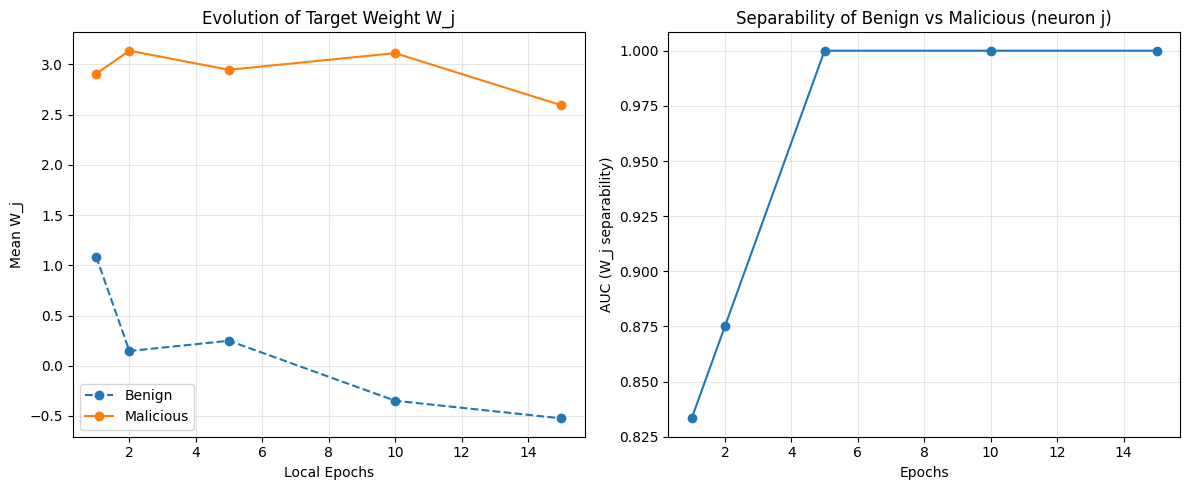

In [19]:
# ---------------------------------------------------------------------
# Continue from your existing code block
# ---------------------------------------------------------------------

from scipy import stats
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

# --- Config for analysis ---
target_j = 9          # index of target neuron
n_boot = 2000         # bootstrap resamples

# --- Step 1: collect W_j for each epoch ---
epoch_results = {}  # {epoch: {"ben": array, "mal": array}}

for epoch in epoch_settings:
    files = [f for f in os.listdir(save_dir) if re.search(rf"epochs_{epoch}\b", f)]
    W_ben, W_mal = [], []

    for f in sorted(files):
        list_of_weights = torch.load(os.path.join(save_dir, f), weights_only=False)
        good_layer = np.array(list_of_weights[0])  # (n_good, out_dim)
        bad_layer = np.array(list_of_weights[1])   # (n_bad, out_dim)

        W_ben.extend(good_layer[:, target_j])
        W_mal.extend(bad_layer[:, target_j])

    epoch_results[epoch] = {
        "ben": np.array(W_ben),
        "mal": np.array(W_mal)
    }

# --- Step 2: compute per-epoch stats ---
traj_rows = []
for epoch, vals in sorted(epoch_results.items()):
    Wb, Wm = vals["ben"], vals["mal"]
    if len(Wb) < 2 or len(Wm) < 2:
        continue
    traj_rows.append({
        "epoch": epoch,
        "mean_ben": np.mean(Wb), "std_ben": np.std(Wb, ddof=1),
        "mean_mal": np.mean(Wm), "std_mal": np.std(Wm, ddof=1)
    })
df_traj = pd.DataFrame(traj_rows)

# --- Step 3: per-client slopes (linear fit of W_j vs epoch) ---
epochs_sorted = sorted(epoch_results.keys())
Xmat = np.vstack([epochs_sorted, np.ones_like(epochs_sorted)]).T  # for least-squares fit


print("\n=== Slope Comparison of W_j over Epochs (neuron {}) ===".format(target_j))
print(f"mean_slope_ben={mean_b:.4f}, mean_slope_mal={mean_m:.4f}, Δ={delta:.4f}, "
      f"Cohen_d={cohens_d:.3f}, 95%CI=[{ci_lower:.4f}, {ci_upper:.4f}]")

# --- Step 5: plotting trajectories and slopes ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# (a) Mean W_j trajectories
axes[0].plot(df_traj["epoch"], df_traj["mean_ben"], "--o", label="Benign")
axes[0].plot(df_traj["epoch"], df_traj["mean_mal"], "-o", label="Malicious")
axes[0].set_xlabel("Local Epochs")
axes[0].set_ylabel(f"Mean W_j")
axes[0].set_title("Evolution of Target Weight W_j")
axes[0].legend()
axes[0].grid(alpha=0.3)

# (b) Separability across epochs (Step 6)
# Compute AUC of W_j distributions at each epoch
auc_rows = []
for epoch, vals in sorted(epoch_results.items()):
    Wb, Wm = vals["ben"], vals["mal"]
    y_true = np.concatenate([np.zeros(len(Wb)), np.ones(len(Wm))])
    Xvals = np.concatenate([Wb, Wm])
    try:
        auc = roc_auc_score(y_true, Xvals)
    except Exception:
        auc = np.nan
    auc_rows.append({"epoch": epoch, "AUC": auc})
df_auc = pd.DataFrame(auc_rows)

axes[1].plot(df_auc["epoch"], df_auc["AUC"], "-o")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("AUC (W_j separability)")
axes[1].set_title(f"Separability of Benign vs Malicious (neuron j)")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()




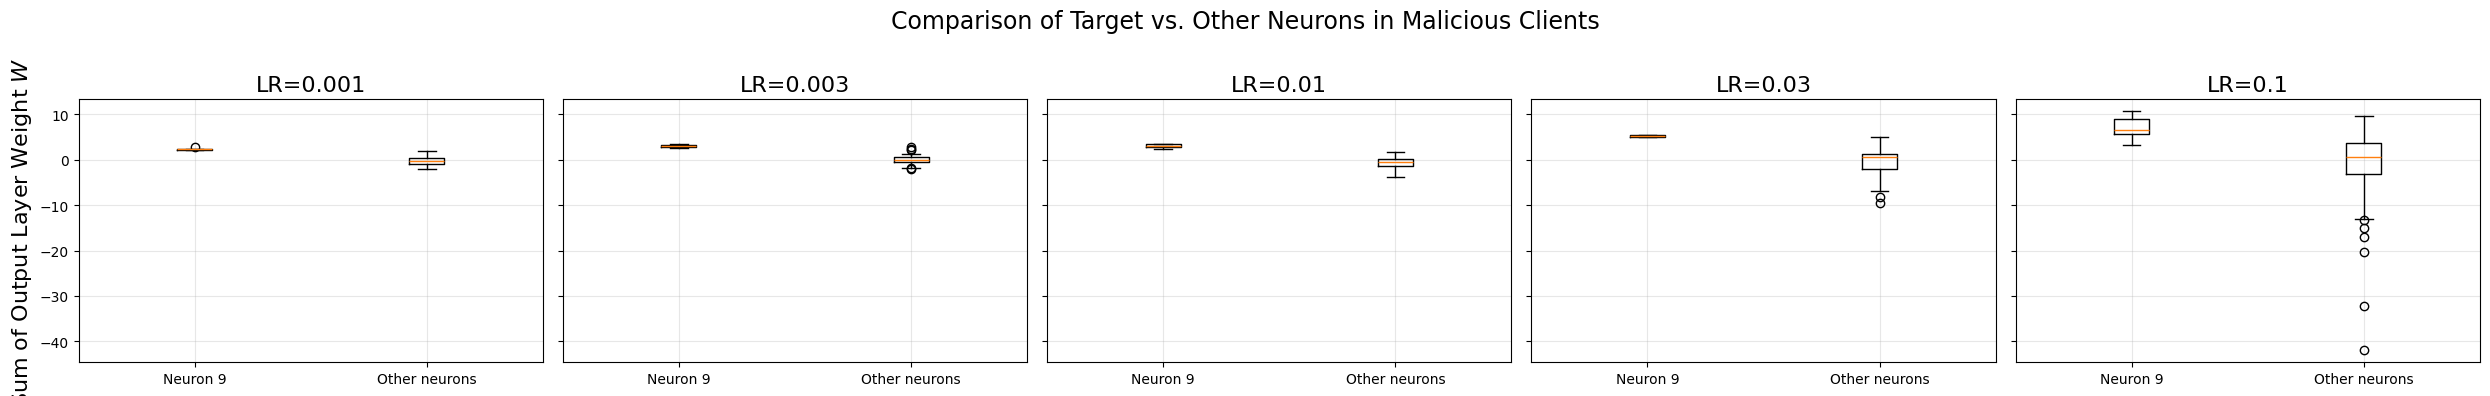


LaTeX Table:

\begin{tabular}{rrrrrr}
\toprule
lr & Mean_Target & Mean_Others & ΔMean & Cohen's_d & AUC \\
\midrule
0.0010 & 2.3519 & -0.3083 & 2.6602 & 3.1919 & 1.0000 \\
0.0030 & 2.9441 & -0.0727 & 3.0168 & 3.4834 & 0.9959 \\
0.0100 & 2.9467 & -0.6111 & 3.5578 & 2.7716 & 1.0000 \\
0.0300 & 5.2150 & -0.6774 & 5.8924 & 2.0042 & 1.0000 \\
0.1000 & 6.8635 & -1.3579 & 8.2213 & 1.0444 & 0.9081 \\
\bottomrule
\end{tabular}



,lr,Mean_Target,Mean_Others,ΔMean,Cohen's_d,AUC
0,0.001,2.351888,-0.308300,2.660188,3.191882,1.000000
1,0.003,2.944143,-0.072666,3.016809,3.483382,0.995885
2,0.010,2.946692,-0.611072,3.557765,2.771563,1.000000
3,0.030,5.214997,-0.677448,5.892445,2.004171,1.000000
4,0.100,6.863478,-1.357868,8.221346,1.044423,0.908093


In [28]:
import numpy as np
import matplotlib.pyplot as plt

def prove_mali_target_vs_others(list_of_settings, setting='lr'):
    # --- Config ---
    target_j = 9  # target neuron index
    results = []  # to store results for table
    fig, axs = plt.subplots(1, len(list_of_settings), figsize=(5*len(list_of_settings), 4), sharey=True)

    for i, config in enumerate(list_of_settings):
        files = [f for f in os.listdir(save_dir) if re.search(rf"{setting}_{config}\b", f)]
        W_target, W_others = [], []

        for f in sorted(files):
            list_of_weights = torch.load(os.path.join(save_dir, f), weights_only=False)
            bad_layer = np.array(list_of_weights[1])   # shape (n_bad, out_dim)
            W_target.extend(bad_layer[:, target_j])
            W_others.extend(np.delete(bad_layer, target_j, axis=1))

        # --- Convert to arrays ---
        W_target = np.array(W_target)
        W_others = np.vstack(W_others)
        W_others_flat = W_others.reshape(-1)

        # --- Compute statistics ---
        mean_target, std_target = np.mean(W_target), np.std(W_target, ddof=1)
        mean_others, std_others = np.mean(W_others_flat), np.std(W_others_flat, ddof=1)
        delta_mean = mean_target - mean_others
        pooled_sn = np.sqrt(((len(W_target)-1)*std_target**2 + (len(W_others_flat)-1)*std_others**2) / (len(W_target)+len(W_others_flat)-2))
        cohens_d = delta_mean / (pooled_sn + 1e-12)

        # 1-D classifier separability (AUC)
        X = np.concatenate([W_others_flat, W_target])
        y = np.concatenate([np.zeros(len(W_others_flat)), np.ones(len(W_target))])
        try:
            auc = roc_auc_score(y, X)
        except Exception:
            auc = np.nan

        results.append({
            setting: config,
            "Mean_Target": mean_target,
            "Mean_Others": mean_others,
            "ΔMean": delta_mean,
            "Cohen's_d": cohens_d,
            'AUC': auc
        })

        # --- Visualization ---
        ax = axs[i] if len(list_of_settings) > 1 else axs
        ax.boxplot([W_target, W_others_flat], tick_labels=[f"Neuron {target_j}", "Other neurons"])
        ax.set_title(f"{setting.upper()}={config}", fontsize=16)
        ax.grid(alpha=0.3)
        if i == 0:
            ax.set_ylabel("Sum of Output Layer Weight $W$", fontsize=16)

    plt.suptitle("Comparison of Target vs. Other Neurons in Malicious Clients", fontsize=17)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- Print LaTeX table ---
    df = pd.DataFrame(results)
    print("\nLaTeX Table:\n")
    print(df.to_latex(index=False, float_format="%.4f"))

    return df

prove_mali_target_vs_others(lr_settings, setting='lr')

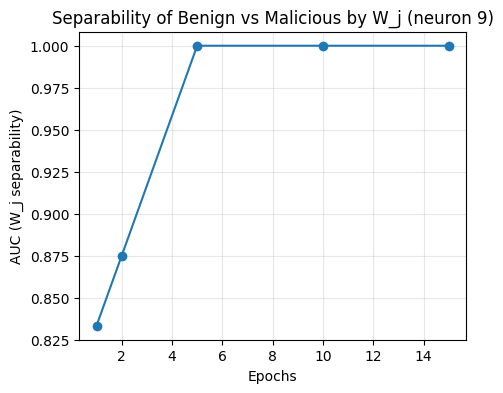

In [24]:
# --- Step 6: separability across epochs (optional) --- 
# Compute AUC of W_j distributions at each epoch 
auc_rows = [] 
for epoch, vals in sorted(epoch_results.items()): 
    Wb, Wm = vals["ben"], vals["mal"] 
    y_true = np.concatenate([np.zeros(len(Wb)), np.ones(len(Wm))]) 
    Xvals = np.concatenate([Wb, Wm]) 
    try: auc = roc_auc_score(y_true, Xvals) 
    except Exception: auc = np.nan 
    auc_rows.append({"epoch": epoch, "AUC": auc}) 
df_auc = pd.DataFrame(auc_rows) 

plt.figure(figsize=(5,4)) 
plt.plot(df_auc["epoch"], df_auc["AUC"], "-o") 
plt.xlabel("Epochs") 
plt.ylabel("AUC (W_j separability)") 
plt.title(f"Separability of Benign vs Malicious by W_j (neuron {target_j})") 
plt.grid(alpha=0.3) 
plt.show()